# 3.11模型选择、欠拟合和过拟合

## 3.11.4多项式函数拟合实验

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("/data/dive")
import d2lzh_pytorch as d2l
print(torch.__version__)

1.3.0+cpu


### 3.11.4.1生成数据集

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
# n_train：训练样本数；n_test：测试样本数
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.1473],
         [ 1.3383]]), tensor([[-0.1473,  0.0217, -0.0032],
         [ 1.3383,  1.7911,  2.3970]]), tensor([ 4.7398, 13.9377]))

### 3.11.14.2定义、训练和测试模型

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    '''
    画图函数
    '''
    # d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals) # y轴对数尺度
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # 初始化网络模型
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以这里就不手动初始化了
    
    # 设置批量大小
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)      # 设置数据集
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True) # 设置获取数据方式
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)                      # 设置优化函数，使用的是随机梯度下降优化
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:                                                 # 取一个批量的数据
            l = loss(net(X), y.view(-1, 1))                                     # 输入到网络中计算输出，并和标签比较求得损失函数
            optimizer.zero_grad()                                               # 梯度清零，防止梯度累加干扰优化
            l.backward()                                                        # 求梯度
            optimizer.step()                                                    # 迭代优化函数，进行参数优化
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())         # 将训练损失保存到train_ls中
        test_ls.append(loss(net(test_features), test_labels).item())            # 将测试损失保存到test_ls中
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

### 3.11.4.3三阶多项式函数拟合（正常）

final epoch: train loss 0.00011262615589657798 test loss 0.00011607878695940599
weight: tensor([[ 1.1988, -3.3992,  5.5994]]) 
bias: tensor([5.0005])


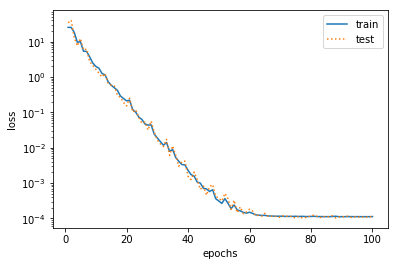

In [6]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

### 3.11.4.4线性函数拟合（欠拟合）

final epoch: train loss 166.3688201904297 test loss 158.37432861328125
weight: tensor([[16.2310]]) 
bias: tensor([3.7915])


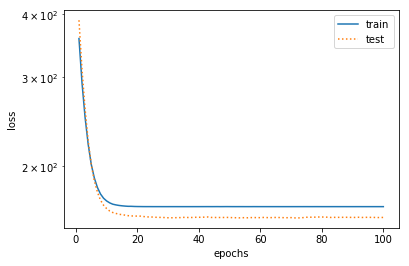

In [7]:
# 特征只用x
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

### 3.11.4.5训练样本不足（过拟合）

final epoch: train loss 1.1498677730560303 test loss 210.29183959960938
weight: tensor([[0.8495, 1.8748, 2.6029]]) 
bias: tensor([3.3206])


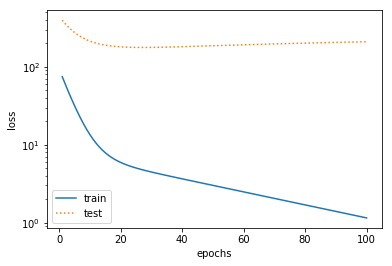

In [8]:
# 样本只有两个
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])